# QuTiP Lecture: Pulse-wise second-order optical coherences of emission from a two-level system

K.A. Fischer, Stanford University

This Jupyter notebook demonstrates how to simulate the second-order coherences of the emission from a two-level system, using QuTiP: The Quantum Toolbox in Python. The purpose is to help characterize the quality of a two-level system as a single-photon source; an ideal pulsed single-photon source has zero net second-order coherence. This notebook closely follows an example from my simulation paper, <a href="http://dx.doi.org/10.1088/1367-2630/18/11/113053">Dynamical modeling of pulsed two-photon interference</a>, published as New J. Phys. 18 113053 (2016).

For more information about QuTiP see the project web page: http://qutip.org/ 

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from qutip import *

In [4]:
from IPython.display import display, Math, Latex

## Introduction

The quantum two-level system (TLS) is the simplest possible model for quantum light-matter interaction. In the version we simulate here, the system is driven by a continuous-mode coherent state, whose dipolar interaction with the system is represented by the following Hamiltonain

$$ H =\hbar \omega_0 \sigma^\dagger \sigma + \frac{\hbar\Omega(t)}{2}\left( \sigma\textrm{e}^{-i\omega_dt} + \sigma^\dagger \textrm{e}^{i\omega_dt}\right),$$

where $\omega_0$ is the system's transition frequency, $\sigma$ is the system's atomic lowering operator, $\omega_d$ is the coherent state's center frequency, and $\Omega(t)$ is the coherent state's driving strength.

The time-dependence can be removed to simplify the simulation by a rotating frame transformation, and is particularly simple when the driving field is resonant with the transition frequency ($\omega_d=\omega_0$). Then,

$$ H_r =\frac{\hbar\Omega(t)}{2}\left( \sigma+ \sigma^\dagger \right).$$

### Problem parameters

We will explore emission from the two-level system under two different regimes: under excitation by a short pulse which gives rise to an exponential wavepacket and under excitation by a long pulse which gives rise to a Gaussian wavepacket. (Short and long are relative to the spontaneous emission time of the atomic transition.) In both cases, the driving strengths are chosen such that the expected number of photodetections is unity, i.e.

$$ \gamma\int \langle \sigma^\dagger (t) \sigma(t)\rangle=1 .$$

As a result, we can compare the statistics of the emission directly and the normalizations become trivial.

Note, we use units where $\hbar=1$.

In [5]:
# shared parameters
gamma = 1                        # decay rate
tlist = np.linspace(0, 13, 300)
taulist = tlist

# parameters for TLS with exponential shape wavepacket (short pulse)
tp_e = 0.060                     # Gaussian pulse parameter
Om_e = 19.40                     # driving strength
t_offset_e = 0.405
pulse_shape_e = Om_e / 2 * np.exp(-(tlist - t_offset_e) ** 2 /
                                  (2 * tp_e ** 2))

# parameters for TLS with Gaussian shape wavepacket (long pulse)
tp_G = 2.000                     # Gaussian pulse parameter
Om_G = 0.702                     # driving strength
t_offset_G = 5
pulse_shape_G = Om_G / 2 * np.exp(-(tlist - t_offset_G) ** 2 /
                                  (2 * tp_G ** 2))

### Setup the operators, Hamiltonian, and initial state

In [6]:
# initial state
psi0 = fock(2, 0)              # ground state

# operators
sm = destroy(2)                # atomic lowering operator
n = [sm.dag()*sm]              # number operator

# Hamiltonian
H_I = sm + sm.dag()
H_e = [[H_I, pulse_shape_e]]
H_G = [[H_I, pulse_shape_G]]

# collapse operator that describes dissipation
c_ops = [np.sqrt(gamma) * sm]  # represents spontaneous emission

## Calculate the emission flux

We evolve the system with the Lindblad master equation solver, and we request that the expectation values of the number operator $\hat{n}=\sigma^{\dagger} \sigma$ are returned by the solver. If the probability of two photodetections were negligible over the course of the pulse, then $\langle \hat{n}(t) \rangle$ would be the probability density of a detection occuring on an ideal detector at time $t$.

In [7]:
n_e = mesolve(H_e, psi0, tlist, c_ops, n).expect[0]
n_G = mesolve(H_G, psi0, tlist, c_ops, n).expect[0]

### Visualize the emission flux

We plot the emission flux from two different two-level systems. The flux labelled 'exponential wavepacket' was generated with a short pulse, while the flux labelled 'Gaussian wavepacket' was generated with a long pulse.

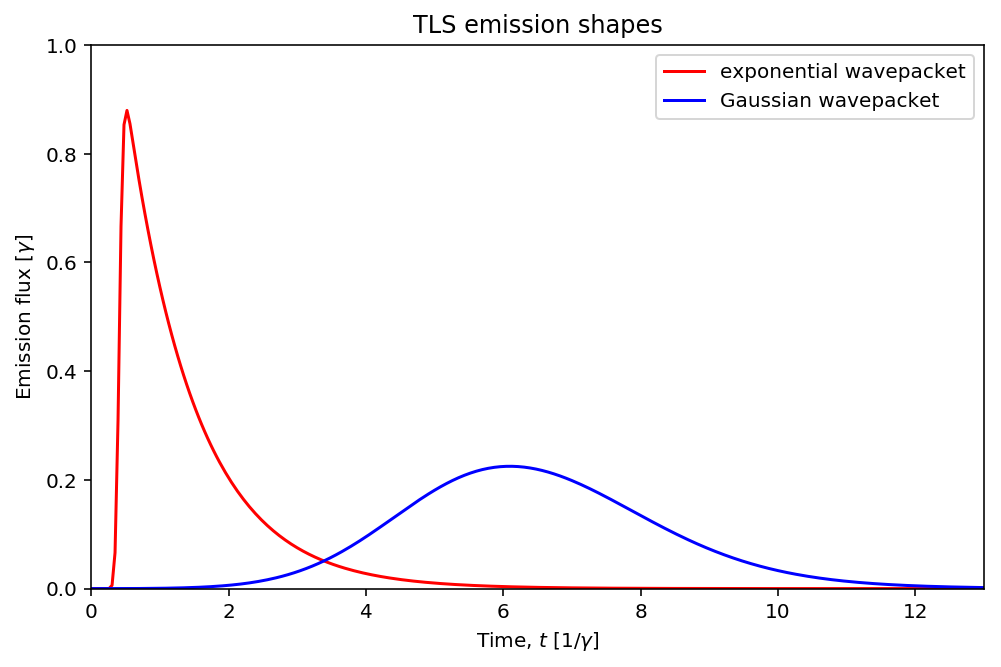

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(tlist, n_e, 'r', label="exponential wavepacket")
ax.plot(tlist, n_G, 'b', label="Gaussian wavepacket")
ax.legend()
ax.set_xlim(0, 13)
ax.set_ylim(0, 1)
ax.set_xlabel('Time, $t$ [$1/\gamma$]')
ax.set_ylabel('Emission flux [$\gamma$]')
ax.set_title('TLS emission shapes');

## Calculate the second-order optical coherences

We are interested in exploring the second-order optical coherences of the emission from the two-level system $G^{(2)}(t,\tau)$. If the probability of three photodetections were negligible over the course of the pulse, then $G^{(2)}(t,\tau)$ would correspond to the probability density of a photodetection at time $t$, followed by a photodetection at time $t+\tau$. Here, we wish to calculate time-dependent photon intensity correlations for a driven two level system with arbitrary pulse length, i.e.

$$ G^{(2)}(t,\tau)= \gamma^2 \langle \sigma^\dagger(t) \sigma^\dagger(t+\tau) \sigma(t+\tau) \sigma(t) \rangle. $$

We identify this correlation to be of the form 

$$ \left< A(t)B(t+\tau)C(t) \right> ,$$

which can be calculated with the QuTiP correlators using the master equation solver and the quantum regression theorem.

In [9]:
# specify relevant operators to calculate the correlation
# <A(t)B(t+tau)C(t)>
a_op = sm.dag()
b_op = sm.dag() * sm
c_op = sm

# calculate two-time correlations
G2_t_tau_e = correlation_3op_2t(H_e, psi0, tlist, taulist, c_ops,
                                a_op, b_op, c_op)
G2_t_tau_G = correlation_3op_2t(H_G, psi0, tlist, taulist, c_ops,
                                a_op, b_op, c_op)

### Visualize the second-order optical coherences

The second-order optical coherences show dramatically different results for the exponential and Gaussian wavepackets. Looking on the axis of the first detection time, the intensity correlations are confined to the width of the pulse because this width denotes the times when the system can be re-excited after the first photodetection. While on the axis of the second detection time, the correlations decay within the sum of the pulse-width plus the decay time. For the exponential wavepacket this results in a narrow sliver of correlation, while for the Gaussian wavepacket this results in a giant blob for correlation.

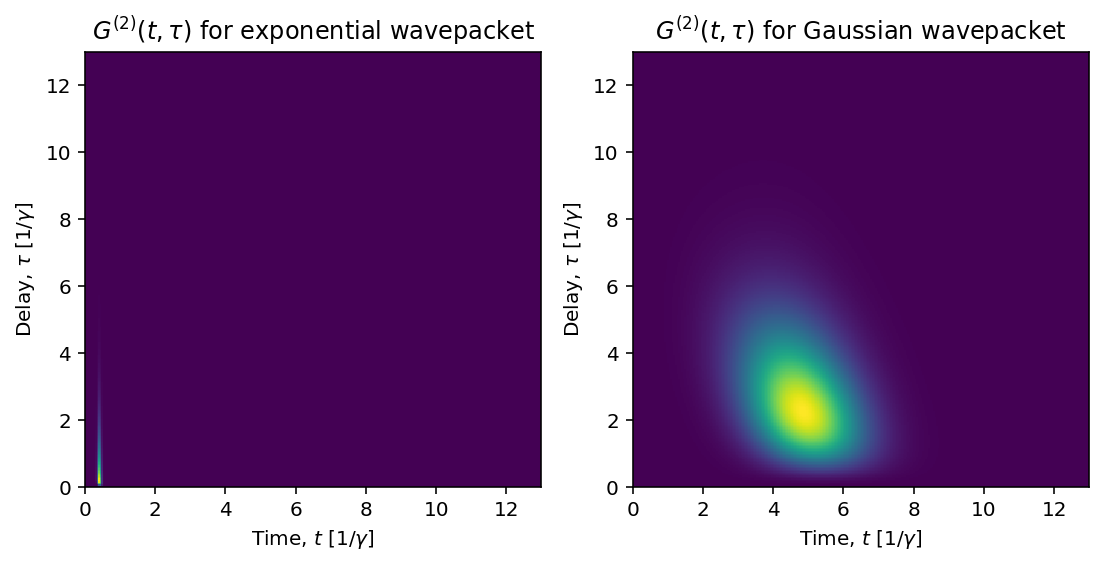

In [10]:
fig = plt.figure(figsize=(9,4))

ax_e = fig.add_subplot(121)
p_e = ax_e.pcolor(tlist/gamma, taulist/gamma,
                  abs(G2_t_tau_e).transpose())
ax_e.set_xlim(0, 13)
ax_e.set_ylim(0, 13)
ax_e.set_xlabel('Time, $t$ [$1/\gamma$]')
ax_e.set_ylabel('Delay, $\\tau$ [$1/\gamma$]')
ax_e.set_title('$G^{(2)}(t,\\tau)$ for exponential wavepacket');

ax_G = fig.add_subplot(122)
p_G = ax_G.pcolor(tlist/gamma, taulist/gamma,
                  abs(G2_t_tau_G).transpose())
ax_G.set_xlim(0, 13)
ax_G.set_ylim(0, 13)
ax_G.set_xlabel('Time, $t$ [$1/\gamma$]')
ax_G.set_ylabel('Delay, $\\tau$ [$1/\gamma$]')
ax_G.set_title('$G^{(2)}(t,\\tau)$ for Gaussian wavepacket');

By integrating over $t$, we arrive at the single time correlation function that describes average correlations between pairs of photons in the wavepacket

$$G^{(2)}(\tau)= \gamma^2 \int \mathop{\textrm{d} t} \, \langle \mathcal{T}_-[\sigma^\dagger(t) \sigma^\dagger(t+\tau)] \mathcal{T}_+[\sigma(t+\tau) \sigma(t)] \rangle,$$

where the operators $\mathcal{T}_\pm$ indicate the time-ordering required of a physical
measurement (higher times toward the center).

This correlator roughly follows the shape of the wavepacket, but is much larger for the longer pulse because the system can be re-excited more times over the course of the pulse.

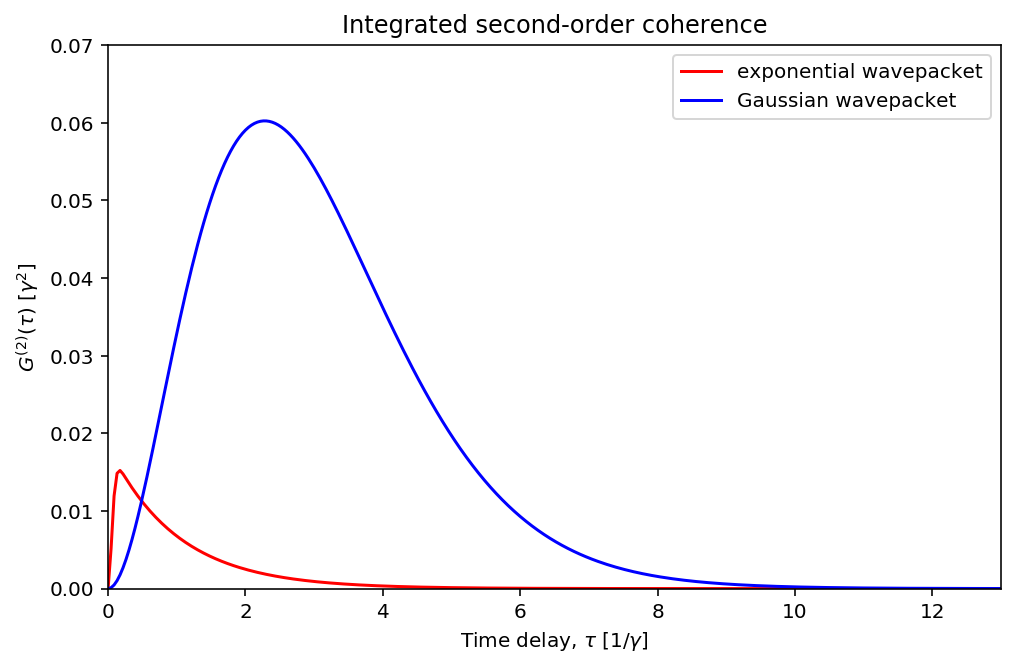

In [11]:
G2_tau_e = abs(np.trapz(G2_t_tau_e.transpose(), tlist))
G2_tau_G = abs(np.trapz(G2_t_tau_G.transpose(), tlist))

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(taulist, abs(G2_tau_e), 'r', label="exponential wavepacket")
ax.plot(taulist, G2_tau_G, 'b', label="Gaussian wavepacket")
ax.legend()
ax.set_xlim(0, 13)
ax.set_ylim(0, 0.07)
ax.set_xlabel('Time delay, $\\tau$ [$1/\gamma$]')
ax.set_ylabel('$G^{(2)}(\\tau)$ [$\gamma^2$]')
ax.set_title('Integrated second-order coherence');

## Calculate measured degrees of second-order optical coherence

The integrated second-order optical coherence is given by

$$ G^{(2)}[0]=\int \mathop{\textrm{d} \tau} G^{(2)}(\tau). $$

It's normalized version, referred to as the 'measured degree of second-order coherence' has the form

$$ g^{(2)}[0] = \frac{G^{(2)}[0]}{\left(\gamma\int \mathop{\textrm{d} t} \langle \hat{n}(t)\rangle\right)^2}, $$

which is simple for us to calculate since we set the expected number of photodetections to unity.

This coherence is low (high) for the exponential (Gaussian) wavepacket, meaning it is relatively unlikely (likely) multiple photodetections will occur over the course of the pulse.

In [12]:
# the factor of two comes from integration of negative taus, whose
# values mirror the positive taus due to the symmetry of G2(t, tau)
g20_e = 2*abs(np.trapz(G2_tau_e, taulist))
g20_G = 2*abs(np.trapz(G2_tau_G, taulist))

display(Math('\\textsf{exponential wavepacket }' + 
             r'g^{(2)}_\text{ME}(0) = ' + str(round(g20_e, 2))))
display(Math('\\textsf{Gaussian wavepacket }' + 
             r'g^{(2)}_\text{ME}(0) = ' + str(round(g20_G, 2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Therefore, the two-level system only acts as a good single-photon source when it is excited with a short pulse.

## Connection to the Monte-Carlo wavefunction approach

The measured degree of second-order coherence can also be calculated using the Monte-Carlo wavefunction approach, where the photocount distribution over the pulse duration is directly estimated. We can use the QuTiP Monte-Carlo solver to estimate this photocount distribution, $P_m(T)$. Then, we can estimate the measured degree of second-order coherence by computing 

$$ \hat{g}^{(2)}[0]= \frac{\langle m(m-1) \rangle} {\langle m \rangle^2}, $$

where the expectations are over $P_m(T)$.

### Simulate the photocount distribution

In [13]:
result_mc_e = mcsolve(H_e, psi0, tlist, c_ops, n,
                      progress_bar=None, ntraj=1000)
result_mc_G = mcsolve(H_G, psi0, tlist, c_ops, n,
                      progress_bar=None, ntraj=1000)

### Estimate the measured degree of second-order coherence

In [14]:
# bin the collapse events to generate Pm
ncollapse_e = [result_mc_e.col_times[i].size
               for i in range(result_mc_e.col_times.size)] 
ncollapse_G = [result_mc_G.col_times[i].size
               for i in range(result_mc_G.col_times.size)]
Pm_e = np.histogram(ncollapse_e, bins=range(20), density=True)[0]
Pm_G = np.histogram(ncollapse_G, bins=range(20), density=True)[0]

# calculate the measured degree of second-order coherence
g20_mc_e = sum([p * m * (m - 1) for m,p in enumerate(Pm_e)])
g20_mc_G = sum([p * m * (m - 1) for m,p in enumerate(Pm_G)])

display(Math('\\textsf{exponential wavepacket }' + 
             r'g^{(2)}_\text{MC}[0] = ' + str(round(g20_mc_e, 2))))
display(Math('\\textsf{Gaussian wavepacket }' + 
             r'g^{(2)}_\text{MC}[0] = ' + str(round(g20_mc_G, 2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Which is in excellent agreement with the values calculated using the quantum regression theorem and the master equation solver.

## Versions

In [15]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.3.0.dev0+6e5b1d43
Numpy,1.13.1
SciPy,0.19.1
matplotlib,2.0.2
Cython,0.25.2
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,6.1.0
Python,"3.6.2 |Anaconda custom (x86_64)| (default, Jul 20 2017, 13:14:59) [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]"
OS,posix [darwin]
